# I. Introduction

Salifort motors is currently facing a high **employee turnover rate**. To address this issue, a model has been developed to predict **whether an employee will leave the company.** 

This model will help HR identify the factors contributing to employee departures and devise effective solutions. Using data from employee surveys, including department, number of projects, average monthly hours, and other relevant information, the model will help HR to develop policies to increase employee retention and improve job satisfaction among current and future employees.

## Data dictionary

| Column Name             | Type   | Description                                                     |
|-------------------------|--------|-----------------------------------------------------------------|
| `satisfaction_level`     | int64  | The employee’s self-reported satisfaction level [0-1]           |
| `last_evaluation`        | int64  | Score of employee's last performance review [0–1]               |
| `number_project`         | int64  | Number of projects employee contributes to                      |
| `average_monthly_hours`  | int64  | Average number of hours employee worked per month               |
| `time_spend_company`     | int64  | How long the employee has been with the company (years)         |
| `work_accident`          | int64  | Whether or not the employee experienced an accident while at work |
| `left`                   | int64  | Whether or not the employee left the company                    |
| `promotion_last_5years`  | int64  | Whether or not the employee was promoted in the last 5 years    |
| `department`             | str    | The employee's department                                       |
| `salary`                 | str    | The employee's salary (low, medium, or high)                    |

In [187]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Import packages for statistical test
from scipy import stats

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay 
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# For saving models
import pickle

## Data Cleaning

In [188]:
# Load the data
df = pd.read_csv('/Users/user/Desktop/projects/salifort_motor/HR_comma_sep.csv')

In [189]:
# Quick view of the data
df.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

In [190]:
# Check for null data and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [191]:
# Display column names
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [192]:
# Correct and Rename columns to snake_case
df = df.rename(columns={'Work_accident':'work_accident', 
                   'average_montly_hours': 'average_monthly_hours',
                   'time_spend_company': 'tenure',
                   'Department':'department'
                  })

In [193]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [194]:
# Check missing value
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [195]:
# Check duplicate
df.duplicated().sum()

3008

In [196]:
# There are 3008 rows of duplicate data that need to be dropped
df_cleaned = df.drop_duplicates(keep='first')

In [197]:
df_cleaned.shape

(11991, 10)

In [198]:
# Reorder the salary column to high -> medium -> low
df_cleaned['salary'] = pd.Categorical(df_cleaned['salary'], categories=['high', 'medium', 'low'], ordered=True)

print(df_cleaned['salary'].cat.categories)

Index(['high', 'medium', 'low'], dtype='object')


/var/folders/8b/8kqdzlwx5j1f14cwsq73fx9w0000gn/T/ipykernel_13943/2076776555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['salary'] = pd.Categorical(df_cleaned['salary'], categories=['high', 'medium', 'low'], ordered=True)


In [199]:
# Check the cleaned data
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     11991 non-null  float64 
 1   last_evaluation        11991 non-null  float64 
 2   number_project         11991 non-null  int64   
 3   average_monthly_hours  11991 non-null  int64   
 4   tenure                 11991 non-null  int64   
 5   work_accident          11991 non-null  int64   
 6   left                   11991 non-null  int64   
 7   promotion_last_5years  11991 non-null  int64   
 8   department             11991 non-null  object  
 9   salary                 11991 non-null  category
dtypes: category(1), float64(2), int64(6), object(1)
memory usage: 948.6+ KB


In [200]:
# Descriptive statistics of the data
df_cleaned.describe()

satisfaction_level  last_evaluation  number_project  \
count        11991.000000     11991.000000    11991.000000   
mean             0.629658         0.716683        3.802852   
std              0.241070         0.168343        1.163238   
min              0.090000         0.360000        2.000000   
25%              0.480000         0.570000        3.000000   
50%              0.660000         0.720000        4.000000   
75%              0.820000         0.860000        5.000000   
max              1.000000         1.000000        7.000000   

       average_monthly_hours        tenure  work_accident          left  \
count           11991.000000  11991.000000   11991.000000  11991.000000   
mean              200.473522      3.364857       0.154282      0.166041   
std                48.727813      1.330240       0.361234      0.372133   
min                96.000000      2.000000       0.000000      0.000000   
25%               157.000000      3.000000       0.000000      0.000000   
50%               200.000000      3.000000       0.000000      0.000000   
75%               243.000000      4.000000       0.000000      0.000000   
max               310.000000     10.000000       1.000000      1.000000   

       promotion_last_5years  
count           11991.000000  
mean                0.016929  
std                 0.129012  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

# II. Exploratory Data Analysis (EDA)

## II. 1 Desciptive Statistics for Stay and Left Employees

In [201]:
# Find out the proportion of Stay and Left employees
df_cleaned['left'].value_counts()

left
0    10000
1     1991
Name: count, dtype: int64

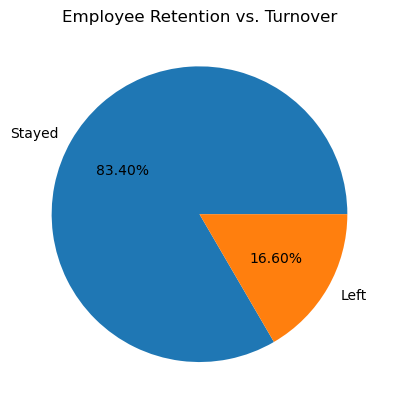

In [202]:
# Visualize the proportion of Stay and Left employees
labels = ['Stayed' if x == 0 else 'Left' for x in df_cleaned['left'].value_counts().index]
plt.pie(df_cleaned['left'].value_counts(), labels = labels, autopct = '%.02f%%')
plt.title('Employee Retention vs. Turnover')
#plt.savefig('employee_retention_vs_turnover.png', dpi=300)
plt.show()

In [203]:
stay = df_cleaned[df_cleaned['left'] == 0]
left = df_cleaned[df_cleaned['left'] == 1]
stay.describe()

satisfaction_level  last_evaluation  number_project  \
count        10000.000000     10000.000000    10000.000000   
mean             0.667365         0.715667        3.786800   
std              0.217082         0.161919        0.981755   
min              0.120000         0.360000        2.000000   
25%              0.540000         0.580000        3.000000   
50%              0.690000         0.710000        4.000000   
75%              0.840000         0.850000        4.000000   
max              1.000000         1.000000        6.000000   

       average_monthly_hours        tenure  work_accident     left  \
count           10000.000000  10000.000000   10000.000000  10000.0   
mean              198.942700      3.262000       0.174500      0.0   
std                45.665507      1.367239       0.379558      0.0   
min                96.000000      2.000000       0.000000      0.0   
25%               162.000000      2.000000       0.000000      0.0   
50%               198.000000      3.000000       0.000000      0.0   
75%               238.000000      4.000000       0.000000      0.0   
max               287.000000     10.000000       1.000000      0.0   

       promotion_last_5years  
count           10000.000000  
mean                0.019500  
std                 0.138281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

In [204]:
left.describe()

satisfaction_level  last_evaluation  number_project  \
count         1991.000000      1991.000000     1991.000000   
mean             0.440271         0.721783        3.883476   
std              0.265207         0.197436        1.817139   
min              0.090000         0.450000        2.000000   
25%              0.110000         0.520000        2.000000   
50%              0.410000         0.790000        4.000000   
75%              0.730000         0.910000        6.000000   
max              0.920000         1.000000        7.000000   

       average_monthly_hours       tenure  work_accident    left  \
count            1991.000000  1991.000000    1991.000000  1991.0   
mean              208.162230     3.881467       0.052737     1.0   
std                61.295145     0.974041       0.223565     0.0   
min               126.000000     2.000000       0.000000     1.0   
25%               146.000000     3.000000       0.000000     1.0   
50%               226.000000     4.000000       0.000000     1.0   
75%               262.500000     5.000000       0.000000     1.0   
max               310.000000     6.000000       1.000000     1.0   

       promotion_last_5years  
count            1991.000000  
mean                0.004018  
std                 0.063277  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

## II. 2 Investigate Variables

### Correlation among Variables

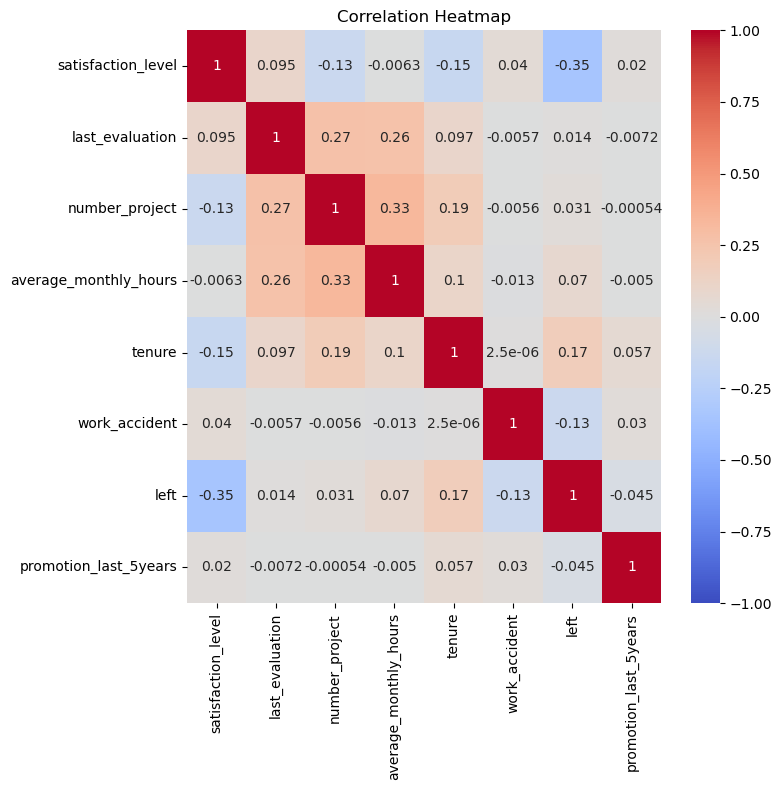

In [205]:
# Correlation Heatmap
plt.show()
plt.figure(figsize=(8, 8))
sns.heatmap(
    df_cleaned
    .corr(numeric_only=True), vmin=-1, vmax=1,
    annot=True, 
    cmap='coolwarm')

plt.title("Correlation Heatmap")
plt.tight_layout()
#plt.savefig('Correlation Heatmap', dpi=300)
plt.show()

From the heatmap of variables, we can observe that the employee satisfaction level has a negative correlation with whether the employee left the company. Additionally, the last evaluation score shows a weak positive correlation with both the number of projects and the average monthly work hours. Furthermore, the number of projects also has a weak moderate positive correlation of 0.33 with the average monthly work hours.

### Relation between Department and Turnover 

In [206]:
# Table of Department by left status
department_left_count = df_cleaned.groupby(['department', 'left']).size().unstack(fill_value=0)

# Percentage of left employees
department_left_count['Left Percentage'] = (department_left_count[1] / 
                                            (department_left_count[0] + department_left_count[1]) * 100).apply(lambda x: f'{x:.2f}%')
department_left_count

left            0    1 Left Percentage
department                            
IT            818  158          16.19%
RandD         609   85          12.25%
accounting    512  109          17.55%
hr            488  113          18.80%
management    384   52          11.93%
marketing     561  112          16.64%
product_mng   576  110          16.03%
sales        2689  550          16.98%
support      1509  312          17.13%
technical    1854  390          17.38%

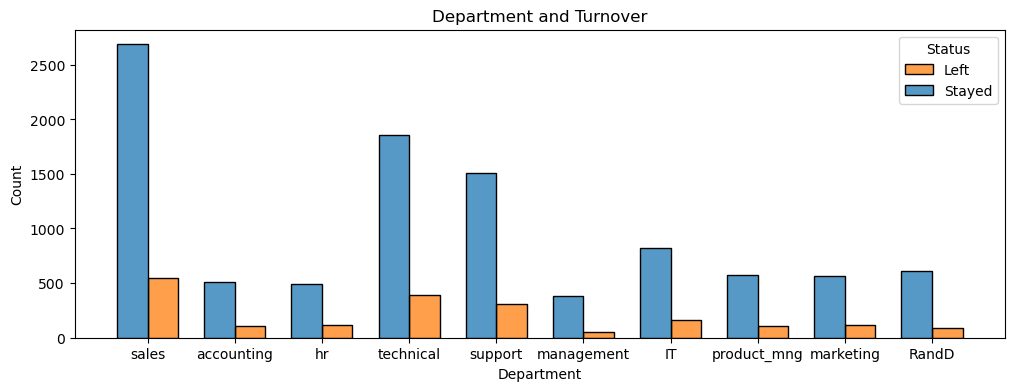

In [207]:
# Visualize Department and Turnover
plt.figure(figsize = (12, 4))
sns.histplot(data = df_cleaned,
            x = 'department', 
            hue = 'left',
            multiple = 'dodge',
            shrink = 0.7
           )
plt.legend(title='Status', labels=['Left', 'Stayed'])
plt.xlabel('Department')
plt.title('Department and Turnover')
plt.savefig('Department and Turnover', dpi=300)
plt.show()

From the histogram of department and turnover, we can observe that the percentage of employees who left ranged from 10% to 20%. The department with the lowest turnover rate was management, while the department with the highest turnover rate was HR.

### Relation between Salary and Turnover 

In [208]:
salary_left_count = df_cleaned.groupby(['salary', 'left']).size().unstack(fill_value=0)

salary_left_count['Left Percentage']=  (salary_left_count[1] / 
                                        (salary_left_count[0]+salary_left_count[1])*100).apply(lambda x: f'{x:.2f}%')
salary_left_count                                        

left       0     1 Left Percentage
salary                            
high     942    48           4.85%
medium  4492   769          14.62%
low     4566  1174          20.45%

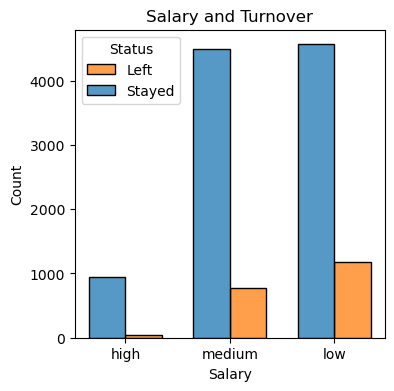

In [209]:
# Visualize Salary and Turnover
plt.figure(figsize = (4, 4))
sns.histplot(data = df_cleaned,
            x = 'salary', 
            hue = 'left',
            multiple = 'dodge',
            shrink = 0.7
           )

plt.legend(title='Status', labels=['Left', 'Stayed'])
plt.xlabel('Salary')
plt.title('Salary and Turnover')
plt.savefig('Salary and Turnover', dpi=300)
plt.show()

The turnover rate increases as salary decreases. Only 4.85% of high-paid employees left, whereas over one-fifth of low-paid employees resigned.

### Relation between Number of Project and Turnover 

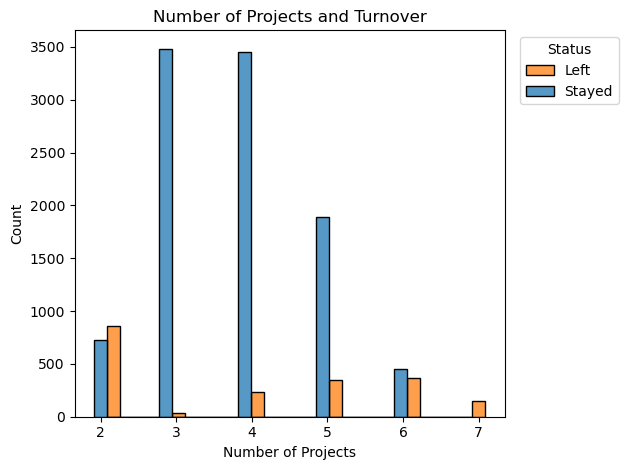

In [210]:
sns.histplot(data = df_cleaned, x = 'number_project', hue = 'left', multiple = 'dodge', shrink = 2)
plt.xlabel('Number of Projects')
plt.title('Number of Projects and Turnover')
plt.legend(title='Status', labels=['Left', 'Stayed'], bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout() 
plt.savefig('Number of Projects and Turnover', dpi=300)
plt.show()

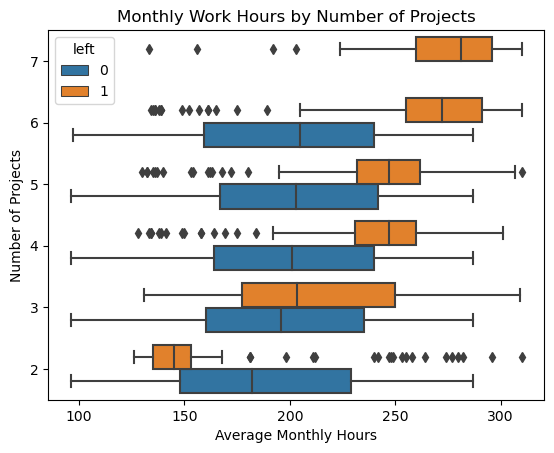

In [211]:
# Investigate relation between number of projects and work hours

sns.boxplot(data = df_cleaned, x = 'average_monthly_hours', y = 'number_project', hue = 'left', orient ='h')
plt.gca().invert_yaxis()

plt.xlabel('Average Monthly Hours')
plt.ylabel('Number of Projects')
plt.title('Monthly Work Hours by Number of Projects')
plt.savefig('Monthly Work Hours by Number of Projects', dpi=300)
plt.show()

The histograms show that all employees handling 7 projects left the company, and nearly half of those working on 6 projects also left. From the box plot of the number of projects and average monthly hours, we can observe that employees who worked on 6 or 7 projects and left had significantly longer average monthly hours.

Interestingly, more than half of the employees working on 2 projects left the company. The bar plot shows that these employees had shorter average monthly work hours compared to those who stayed. A potential reason for these employees working on 2 projects being let go could be that they did not meet the company’s expectations and were subsequently fired.

### Relation between Satisfaction level and Turnover

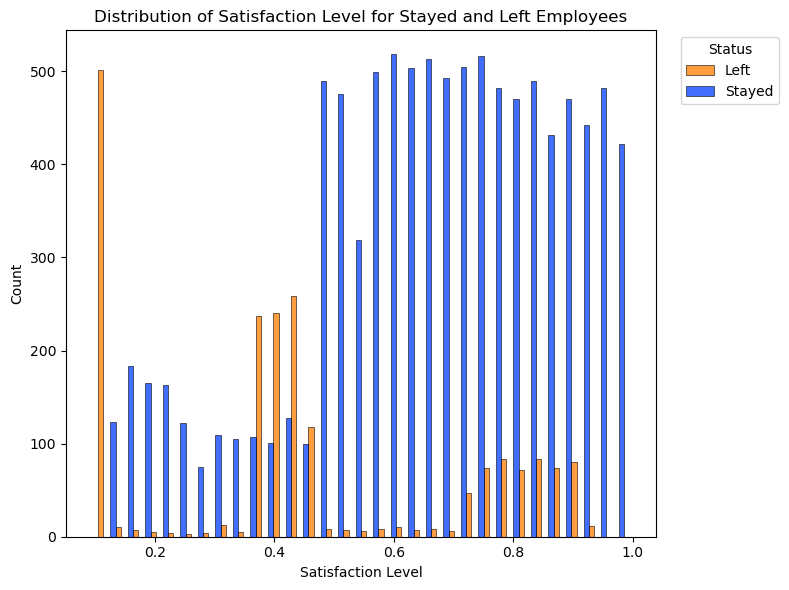

In [212]:
plt.figure(figsize=(8,6))
sns.histplot(data = df_cleaned, stat = 'count', multiple = 'dodge', x = 'satisfaction_level',
            kde = False, palette='bright', hue = 'left', element = 'bars', legend = True, shrink = 0.6)

plt.legend(title='Status', labels=['Left', 'Stayed'], bbox_to_anchor=(1.03, 1), loc='upper left')

plt.xlabel('Satisfaction Level')
plt.title('Distribution of Satisfaction Level for Stayed and Left Employees')
plt.tight_layout() 
plt.savefig('Distribution of Satisfaction Level for Stay and Left Employees', dpi=300)
plt.show()

The distribution of satisfaction levels for employees who left reveals three distinct sections. The first group consists of employees with satisfaction levels below 0.2. The second group has satisfaction levels around 0.4, and the third group ranges from 0.7 to 0.9. 

This pattern suggests that a low satisfaction level was not the only reason employees decided to leave the company. Employees with higher satisfaction levels may have left for other reasons as well.

### Relation between Work Hours and Turnover

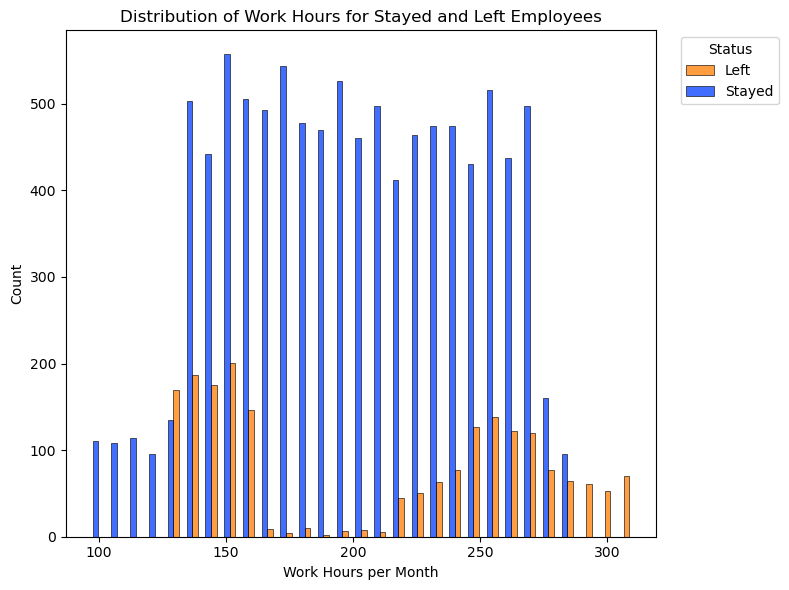

In [276]:
plt.figure(figsize=(8,6))
sns.histplot(data = df_cleaned, stat = 'count', multiple = 'dodge', x = 'average_monthly_hours',
            kde = False, palette='bright', hue = 'left', element = 'bars', legend = True,  shrink = 0.6)

plt.legend(title='Status', labels=['Left', 'Stayed'], bbox_to_anchor=(1.03, 1), loc='upper left')

plt.xlabel('Work Hours per Month')
plt.title('Distribution of Work Hours for Stayed and Left Employees')
plt.tight_layout()
plt.savefig('Distribution of Work Hours for Stayed and Left Employees', dpi=300)
plt.show()

From the distribution of work hours for employees who left, we can observe two distinct groups: one with employees working around 150 hours per month, and another with work hours ranging from 200 to over 300 hours.

The data also suggests that assigning employees to work less than 200 hours per month might be a more optimal option.

### Satisfaction Score and Work Hours

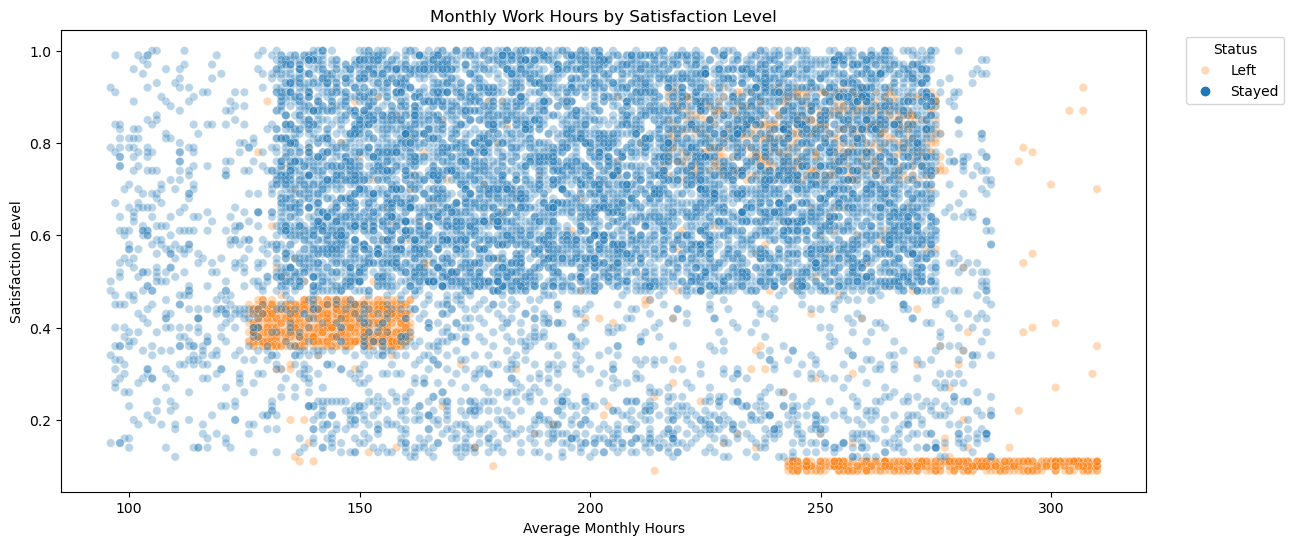

In [310]:
plt.figure(figsize=(14,6))
sns.scatterplot(data = df_cleaned, x = 'average_monthly_hours', y = 'satisfaction_level', hue = 'left', alpha = 0.3)

plt.legend(title='Status', labels=['Left', 'Stayed'], bbox_to_anchor=(1.03, 1), loc='upper left')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Satisfaction Level')
plt.title('Monthly Work Hours by Satisfaction Level')
#plt.savefig('Monthly Work Hours by Satisfaction Level', dpi=300, bbox_inches='tight')
plt.show()

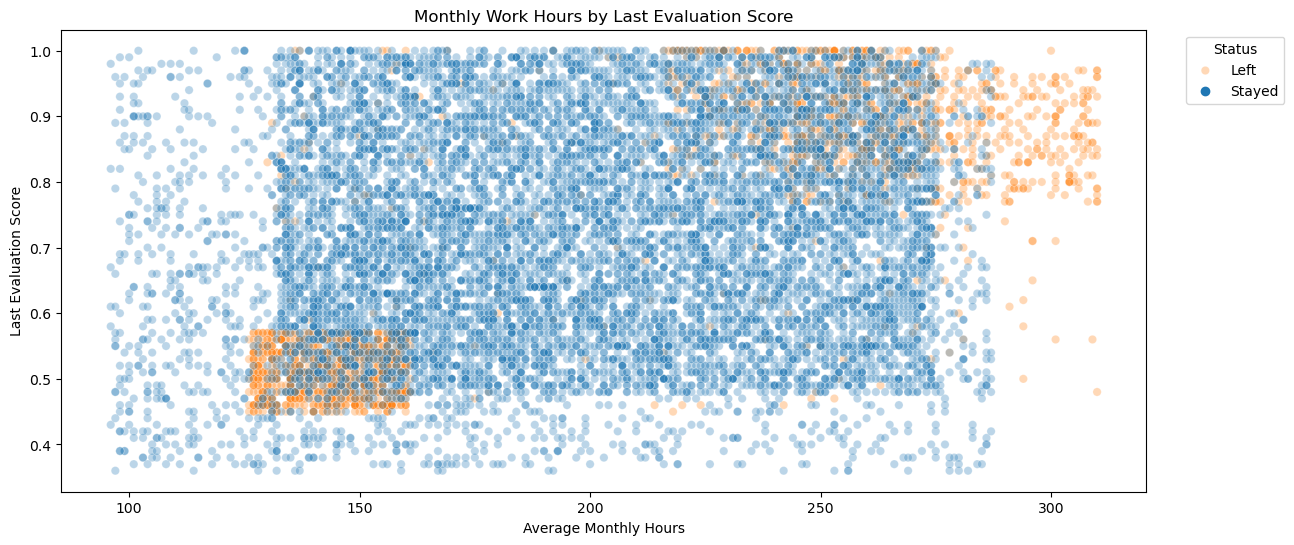

In [319]:
plt.figure(figsize=(14,6))
sns.scatterplot(data = df_cleaned, x = 'average_monthly_hours', y = 'last_evaluation', hue = 'left', alpha = 0.3)
plt.legend(title='Status', labels=['Left', 'Stayed'], bbox_to_anchor=(1.03, 1), loc='upper left')
plt.ylabel('Last Evaluation Score')
plt.xlabel('Average Monthly Hours')
plt.title('Monthly Work Hours by Last Evaluation Score')
plt.savefig('Monthly Work Hours by Last Evaluation Score', dpi=300, bbox_inches='tight')
plt.show()

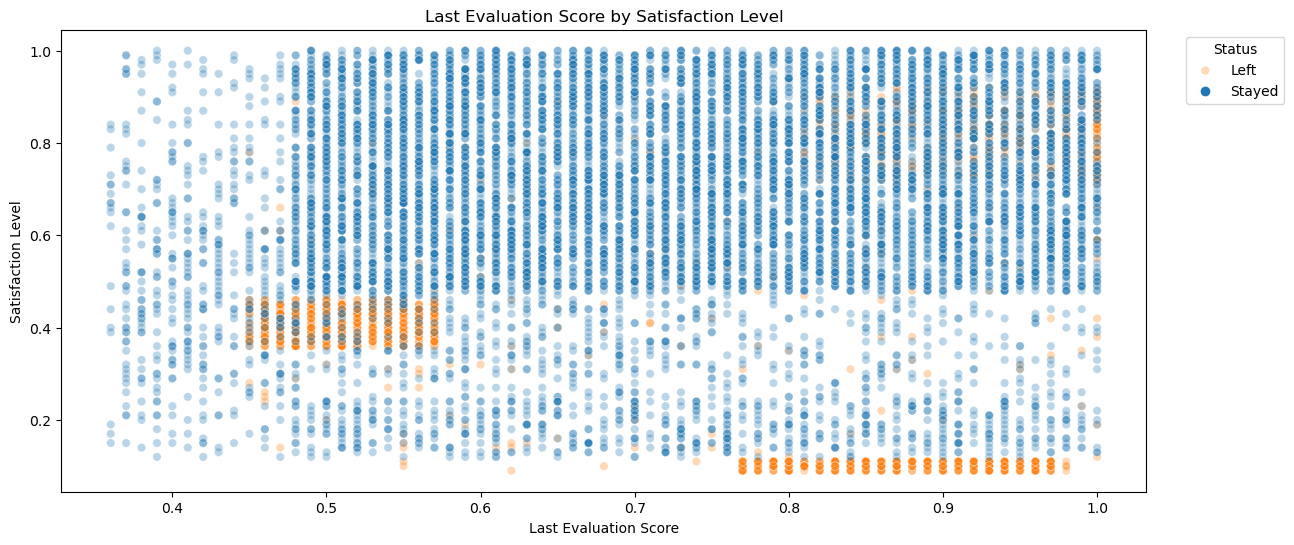

In [320]:
plt.figure(figsize=(14,6))
sns.scatterplot(data = df_cleaned, x = 'last_evaluation', y = 'satisfaction_level', hue = 'left', alpha = 0.3)
plt.legend(title='Status', labels=['Left', 'Stayed'], bbox_to_anchor=(1.03, 1), loc='upper left')

plt.xlabel('Last Evaluation Score')
plt.ylabel('Satisfaction Level')
plt.title('Last Evaluation Score by Satisfaction Level')
plt.savefig('Last Evaluation Score by Satisfaction Level', dpi=300, bbox_inches='tight')
plt.show()

# III. Statistical Tests

After the EDA, several hypothesis tests were conducted to further validate the differences between left and stayed employees.

#### Null Hypothesis and Alternative Hypothesis
**$H_0$** : There is no difference in **x** between left and stayed employees.

**$H_A$** : There is difference in **x** between left and stayed employees.

We choose 5% as the significance level.

In [215]:
# Remind ourselves the variables we got
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     11991 non-null  float64 
 1   last_evaluation        11991 non-null  float64 
 2   number_project         11991 non-null  int64   
 3   average_monthly_hours  11991 non-null  int64   
 4   tenure                 11991 non-null  int64   
 5   work_accident          11991 non-null  int64   
 6   left                   11991 non-null  int64   
 7   promotion_last_5years  11991 non-null  int64   
 8   department             11991 non-null  object  
 9   salary                 11991 non-null  category
dtypes: category(1), float64(2), int64(6), object(1)
memory usage: 948.6+ KB


## III.1 2 Sample T-test

In [216]:
# Conduct a two-sample t-test to satisfaction level
statistic_sl, pvalue_sl = stats.ttest_ind(a = stay['satisfaction_level'], b = left['satisfaction_level'] , equal_var=False)

# Conduct a two-sample t-test to number of project
statistic_nump, pvalue_nump = stats.ttest_ind(a = stay['number_project'], b = left['number_project'] , equal_var=False)

# Conduct a two-sample t-test to last evaluation score
statistic_le, pvalue_le = stats.ttest_ind(a=stay['last_evaluation'], b=left['last_evaluation'], equal_var=False)

# Conduct a two-sample t-test to the Average Hour Worked per month
statistic_amh, pvalue_amh = stats.ttest_ind(a=stay['average_monthly_hours'], b=left['average_monthly_hours'], equal_var=False)

# Conduct a two-sample t-test to the tenure
statistic_ten, pvalue_ten = stats.ttest_ind(a=stay['tenure'], b=left['tenure'], equal_var=False)

In [311]:
# Create a result table
test_result_table = pd.DataFrame({
    'Test': ['Satisfaction Level', 'Number of Project', 'Last Evaluation', 'Average Hour Worked per month', 'Tenure'],
    'T statistic': [statistic_sl, statistic_nump, statistic_le, statistic_amh, statistic_ten],
    'P-Value': [pvalue_sl, pvalue_nump, pvalue_le, pvalue_amh, pvalue_ten],
}).reset_index(drop = True)

test_result_table

Test  T statistic        P-Value
0             Satisfaction Level    35.889305  1.193954e-228
1              Number of Project    -2.307798   2.110164e-02
2                Last Evaluation    -1.298041   1.943907e-01
3  Average Hour Worked per month    -6.368797   2.267947e-10
4                         Tenure   -24.049801  5.787450e-119

Results from 2 sample t-tests show that employees who left and those who stayed differ significantly in satisfaction level, number of projects, average work hours, and tenure. Employees who stayed have significantly higher satisfaction levels compared to those who left. In terms of the number of projects, employees who left worked on more projects than those who stayed, which also holds true for average work hours. Regarding tenure, the results reveal that, employees who left had been with the company for a longer period on average.

## III.2 Chi-square test of independence

#### Null Hypothesis and Alternative Hypothesis
**$H_0$** : The variable x and whether an employee left the company are independent.

**$H_A$** : The variable x and whether an employee left the company are not independent.

We choose 5% as the significance level.

### Work Accident and Turnover

In [218]:
wa_left = df_cleaned.groupby(['work_accident', 'left']).size().unstack(fill_value=0)
wa_left['Left Percentage']=  (wa_left[1] / 
                                        (wa_left[0]+wa_left[1])*100).apply(lambda x: f'{x:.2f}%')

wa_left

left              0     1 Left Percentage
work_accident                            
0              8255  1886          18.60%
1              1745   105           5.68%

In [219]:
# Conduct chi-square test of independence to investigate whether
# 'left' and 'work_accident' are independent

# Create a contingency table
contingency_table = pd.crosstab(df_cleaned['work_accident'], df_cleaned['left'])
# Apply the chi-squared test
chi2_stat_wa, p_val_wa, dof_wa, expected_wa = stats.chi2_contingency(contingency_table, correction=False)

In [220]:
# Output the result
print(f"Chi-Square Statistic: {chi2_stat_wa}")
print(f"P-Value: {p_val_wa}")
print(f"Degrees of Freedom: {dof_wa}")
print("Expected frequencies:")
print(expected_wa)

Chi-Square Statistic: 188.66987572389968
P-Value: 6.204026915138356e-43
Degrees of Freedom: 1
Expected frequencies:
[[8457.17621549 1683.82378451]
 [1542.82378451  307.17621549]]


### Promotion and Turnover

In [221]:
pro_left = df_cleaned.groupby(['promotion_last_5years', 'left']).size().unstack(fill_value=0)
pro_left['Left Percentage']=  (pro_left[1] / 
                                        (pro_left[0]+pro_left[1])*100).apply(lambda x: f'{x:.2f}%')

pro_left

left                      0     1 Left Percentage
promotion_last_5years                            
0                      9805  1983          16.82%
1                       195     8           3.94%

In [222]:
# Conduct chi-square test of independence to investigate whether
# 'left' and 'promotion_last_5years' are independent

# Create a contingency table
contingency_table = pd.crosstab(df_cleaned['promotion_last_5years'], df_cleaned['left'])
# Apply the chi-squared test
chi2_stat_pro, p_val_pro, dof_pro, expected_pro = stats.chi2_contingency(contingency_table, correction=False)

In [223]:
# Output the result
print(f"Chi-Square Statistic: {chi2_stat_pro}")
print(f"P-Value: {p_val_pro}")
print(f"Degrees of Freedom: {dof_pro}")
print("Expected frequencies:")
print(expected_pro)

Chi-Square Statistic: 23.913330119223744
P-Value: 1.0077156627199523e-06
Degrees of Freedom: 1
Expected frequencies:
[[9830.70636311 1957.29363689]
 [ 169.29363689   33.70636311]]


### Salary and Turnover

In [224]:
salary_left_count               

left       0     1 Left Percentage
salary                            
high     942    48           4.85%
medium  4492   769          14.62%
low     4566  1174          20.45%

In [225]:
# Conduct a chi-square test of independence to investigate whether
# 'left' and 'salary' are independent

# Create a contingency table
contingency_table = pd.crosstab(df_cleaned['salary'], df_cleaned['left'])
# Apply the chi-squared test
chi2_stat_sal, p_val_sal, dof_sal, expected_sal = stats.chi2_contingency(contingency_table, correction=False)

In [226]:
# Output the result
print(f"Chi-Square Statistic: {chi2_stat_sal}")
print(f"P-Value: {p_val_sal}")
print(f"Degrees of Freedom: {dof_sal}")
print("Expected frequencies:")
print(expected_sal)

Chi-Square Statistic: 175.21071935727466
P-Value: 8.984123357404531e-39
Degrees of Freedom: 2
Expected frequencies:
[[ 825.61921441  164.38078559]
 [4387.45725961  873.54274039]
 [4786.92352598  953.07647402]]


In [227]:
# Create a result table
chi_result_table = pd.DataFrame({
    'Chi-square test': ['Work Accident', 'Promotion', 'Salary'],
    'Chi-Square Statistic': [chi2_stat_wa, chi2_stat_pro, chi2_stat_sal],
    'P-Value': [p_val_wa, p_val_pro, p_val_sal],
}).reset_index(drop = True)

chi_result_table

Chi-square test  Chi-Square Statistic       P-Value
0   Work Accident            188.669876  6.204027e-43
1       Promotion             23.913330  1.007716e-06
2          Salary            175.210719  8.984123e-39

The results of the Chi-square test showed that work accidents, promotions, and salary were not distributed independently between employees who stayed and those who left. For work accidents, a higher percentage of employees who stayed experienced them, suggesting this may not be a reason for leaving. In terms of promotions, employees who did not receive a promotion in the last five years had a higher chance of leaving. Salary also appears to be a factor, as low-paid employees had a higher probability of leaving the company. Therefore, salary may influence employees’ decisions to leave.

# IV. Model Building

After conducting statistical tests on various features, we will now move on to building models to predict whether an employee will leave the company. We will test three machine learning models, including logistic regression, decision tree, and random forest. Additionally, we will incorporate feature engineering on decision tree and random forest model to evaluate whether the model’s performance improves.

## IV.1 Logistic Regression Model

In [228]:
# Copy data for logistic regression
df_lr = df_cleaned.copy()

Logistic Regression is sensitive to outliers, so we remove the outliers in the tenure column

In [229]:
p25 = df_lr['tenure'].quantile(0.25)
p75 = df_lr['tenure'].quantile(0.75)
iqr = p75 - p25
lower_limit = p25 - 1.5*iqr
upper_limit = p75 + 1.5*iqr

df_lr = df_lr[(df_lr['tenure'] >= lower_limit) & (df_lr['tenure'] <= upper_limit)]

In [230]:
# Encode the categorical variable: salary and department
df_lr['salary'] = (df_lr['salary'].astype('category')
                   .cat.set_categories(['low', 'medium', 'high'])
                   .cat.codes)

df_lr = pd.get_dummies(df_lr, drop_first = False)

In [231]:
# Check the encoded data
df_lr.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  left  promotion_last_5years  salary  department_IT  \
0       3              0     1                      0       0          False   
2       4              0     1                      0       1          False   
3       5              0     1                      0       0          False   
4       3              0     1                      0       0          False   
5       3              0     1                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   
5             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   
5                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False  
5              True               False                 False

In [232]:
# Set y and X variables
y = df_lr['left']

X = df_lr.drop('left', axis = 1)

In [233]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [234]:
# Construct logistic regression model and fit the training set
log_clf = LogisticRegression(random_state=42, max_iter=700).fit(X_train, y_train)

In [235]:
# Get prediection from the test set
y_pred = log_clf.predict(X_test)

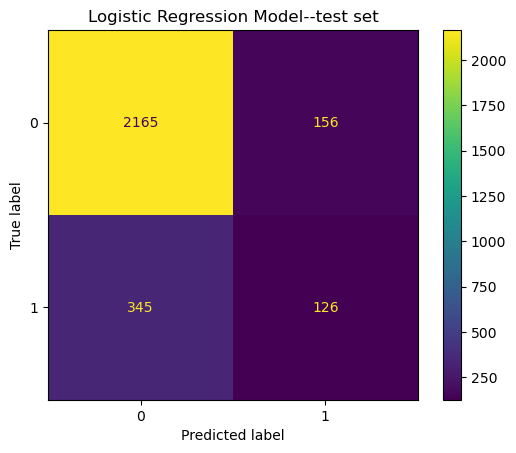

In [236]:
# Create a confusion matrix to visualize predicted and real values
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')
plt.title('Logistic Regression Model--test set')
#plt.savefig('Logistic Regression Model--test set', dpi=300)
plt.show()

In [237]:
# Create classification report for logistic regression model
target_names = ['Predicted would stay', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

 Predicted would stay       0.86      0.93      0.90      2321
Predicted would leave       0.45      0.27      0.33       471

             accuracy                           0.82      2792
            macro avg       0.65      0.60      0.62      2792
         weighted avg       0.79      0.82      0.80      2792



Although the logistic regression model achieved an adequate overall accuracy score (82%), the primary objective of the model is to predict which employees are likely to leave. In this regard, this model did not perform well.

In [238]:
# predict probability
y_pred_prob = log_clf.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score for logistic model: {roc_auc}')

ROC AUC Score for logistic model: 0.8829381141996231


## IV.2 Tree-based Model

### 1. Decision Tree Model

In [239]:
# Encode Categorical Variables
df_tree = df_cleaned.copy()
df_tree['salary'] = (df_cleaned['salary'].astype('category')
                   .cat.set_categories(['low', 'medium', 'high'])
                   .cat.codes)

df_tree = pd.get_dummies(df_tree, drop_first = False)

In [240]:
# Set y and X variables
y = df_tree['left']

X = df_tree.drop('left', axis = 1)
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  promotion_last_5years  salary  department_IT  \
0       3              0                      0       0          False   
1       6              0                      0       1          False   
2       4              0                      0       1          False   
3       5              0                      0       0          False   
4       3              0                      0       0          False   

   department_RandD  department_accounting  department_hr  \
0             False                  False          False   
1             False                  False          False   
2             False                  False          False   
3             False                  False          False   
4             False                  False          False   

   department_management  department_marketing  department_product_mng  \
0                  False                 False                   False   
1                  False                 False                   False   
2                  False                 False                   False   
3                  False                 False                   False   
4                  False                 False                   False   

   department_sales  department_support  department_technical  
0              True               False                 False  
1              True               False                 False  
2              True               False                 False  
3              True               False                 False  
4              True               False                 False

In [241]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [242]:
# Build a decision tree model
tree = DecisionTreeClassifier(random_state = 0)

# Hyperparameters options
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [1, 2, 5],
             'min_samples_split': [2, 4, 6]
             }

# Scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch with cross validation
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [243]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 2.25 s, sys: 880 ms, total: 3.13 s
Wall time: 2.08 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [244]:
# Check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

Since the data is imbalanced, it is recommended to evaluate model performance using the ROC AUC score.

In [245]:
# Check best AUC score on CV
tree1.best_score_

0.969819392792457

In [246]:
# Build a make_results funtion to save the performance of cv scores from different models.
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [247]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819

In [248]:
# Build a get_scores funtion to save the performance of test set scores from different models.
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)
    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [249]:
# Get predictions on test data
tree1_test_scores = get_scores('Decision tree1 test', tree1, X_test, y_test)
tree1_test_scores

model  precision    recall        f1  accuracy       AUC
0  Decision tree1 test   0.936214  0.913655  0.924797  0.975317  0.950627

The decision tree model achieved a ROC AUC score of 95.0% on test set, which is quite good. Next, we build a random forest model. By combining the results from multiple decision trees, the random forest model helps prevent the problem of overfitting.

### 2. Random Forest Model

In [250]:
# Build the model
rf = RandomForestClassifier(random_state=0)

# Hyperparameters options
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Scoring metrics 
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [251]:
%%time
rf1.fit(X_train, y_train) 

CPU times: user 12min 50s, sys: 16 s, total: 13min 7s
Wall time: 13min 11s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

Fitting the random forest model takes a long time. To save time, we save the results in a pickle file to avoid refitting the model if it needs to be used again in the future.

In [252]:
# Define a path to the folder where you want to save the model
path = '/Users/user/Desktop/projects/salifort_motor/'

In [253]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [254]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [255]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [256]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [257]:
# Check best AUC score on CV
rf1.best_score_

0.9804250949807172

In [258]:
# Check best parameters
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

In [259]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


In [260]:
# Get predictions on test data
rf1_test_scores = get_scores('Random Forest1 test', rf1, X_test, y_test)
print(tree1_test_scores)
print(rf1_test_scores)

                 model  precision    recall        f1  accuracy       AUC
0  Decision tree1 test   0.936214  0.913655  0.924797  0.975317  0.950627
                 model  precision    recall        f1  accuracy       AUC
0  Random Forest1 test   0.964211  0.919679  0.941418  0.980987  0.956439


The random forest model achieved a ROC AUC score of 95.6%, which is slightly better than the single decision tree model.

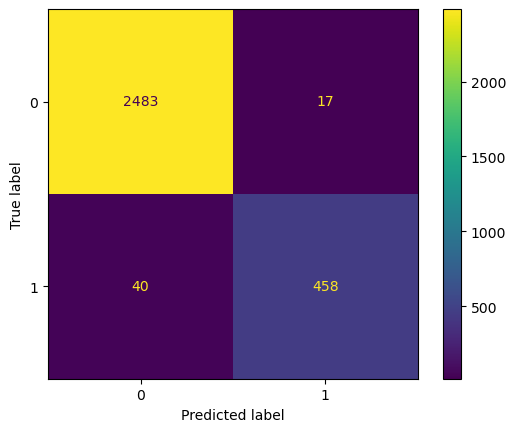

In [261]:
preds = rf1.best_estimator_.predict(X_test)
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_)
disp.plot(values_format='');
plt.title('Random Forest Model--test set')
plt.show()

### Feature Engineering

The high performance of the above models may be caused by data leakage.It's possible that the `average_monthly_hours` column is a source of some data leakage. If employees have already decided upon quitting, or have already been identified by management as people to be fired, they may be working fewer hours. 

The first round of decision tree and random forest models included all variables as features. This next round will incorporate feature engineering to build improved models. 

You could proceed by dropping `satisfaction_level` and creating a new feature that roughly captures whether an employee is overworked. Call this new feature `overworked`. `overworked` is defined as working over 175 hours a month. It will be a binary variable.

In [289]:
df_fe = df_tree.drop('satisfaction_level', axis = 1)
df_fe.shape

(11991, 18)

In [290]:
# Create 'overworked' column
df_fe['overworked'] = df_fe['average_monthly_hours']

# Define `overworked` as working > 175 hrs/month
df_fe['overworked'] = (df_fe['overworked'] > 175).astype(int)

In [291]:
# Drop the original `average_monthly_hours` column
df_fe = df_fe.drop('average_monthly_hours', axis=1)

# Display first few rows of new column
df_fe.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  salary  department_IT  department_RandD  \
0                      0       0          False             False   
1                      0       1          False             False   
2                      0       1          False             False   
3                      0       0          False             False   
4                      0       0          False             False   

   department_accounting  department_hr  department_management  \
0                  False          False                  False   
1                  False          False                  False   
2                  False          False                  False   
3                  False          False                  False   
4                  False          False                  False   

   department_marketing  department_product_mng  department_sales  \
0                 False                   False              True   
1                 False                   False              True   
2                 False                   False              True   
3                 False                   False              True   
4                 False                   False              True   

   department_support  department_technical  overworked  
0               False                 False           0  
1               False                 False           1  
2               False                 False           1  
3               False                 False           1  
4               False                 False           0

In [264]:
# Outcome variable
y_fe = df_fe['left']

# Select the features
X_fe = df_fe.drop('left', axis=1)

### 3. Decision Tree with Feature Engineering

In [265]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, test_size=0.25, stratify=y, random_state=0)

In [266]:
# Build model
tree = DecisionTreeClassifier(random_state = 0)

# Hyperparameter Options
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Scoring metrics 
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring = scoring, cv = 4, refit='roc_auc')

In [267]:
%%time
tree2.fit(X_train, y_train)

CPU times: user 1.78 s, sys: 61.5 ms, total: 1.84 s
Wall time: 1.52 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [268]:
# Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [269]:
# Check best AUC score on CV
tree2.best_score_

0.9586752505340426

In [270]:
# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


In [271]:
# Get predictions on test data
tree2_test_scores = get_scores('Decision tree2 test', tree2, X_test, y_test)
print(tree1_test_scores)
print(rf1_test_scores)
print(tree2_test_scores)

                 model  precision    recall        f1  accuracy       AUC
0  Decision tree1 test   0.936214  0.913655  0.924797  0.975317  0.950627
                 model  precision    recall        f1  accuracy       AUC
0  Random Forest1 test   0.964211  0.919679  0.941418  0.980987  0.956439
                 model  precision    recall        f1  accuracy       AUC
0  Decision tree2 test   0.783877  0.917671  0.845513  0.944296  0.933635


Although the ROC AUC score decreased to 93.3%, the model with feature engineering still achieved acceptable performance. Furthermore, we can confirm that the issue of data leakage has been addressed.

#### Visualization of the decision tree

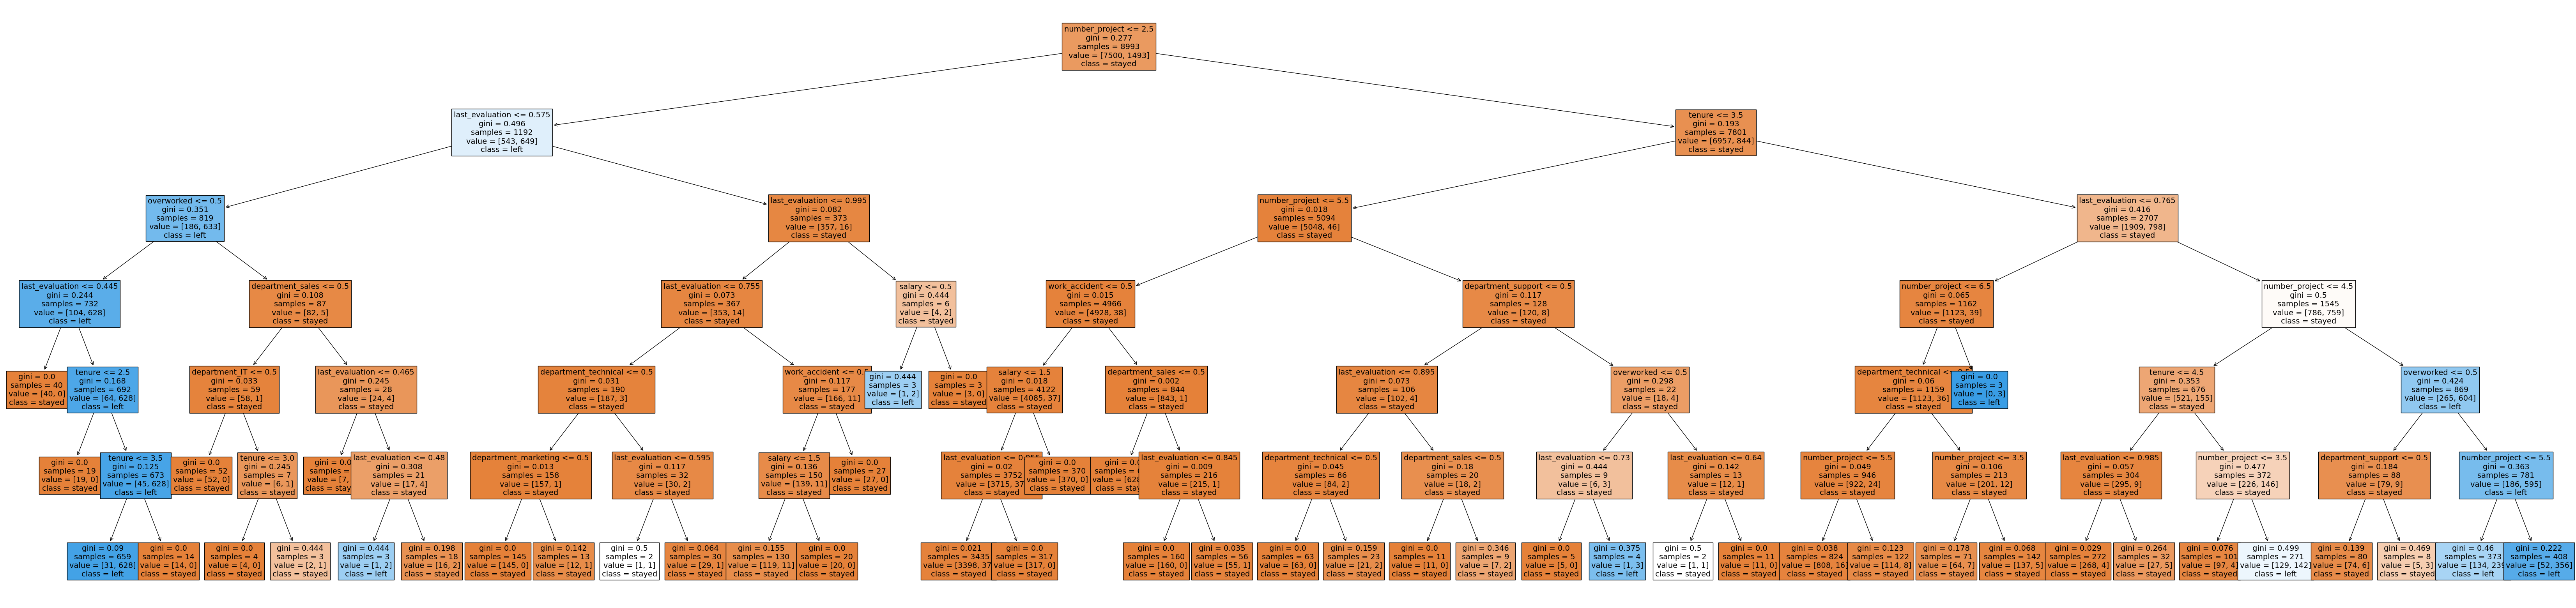

In [294]:
# Convert X.columns to a list
feature_names = X_fe.columns.tolist()

# Plot the tree
plt.figure(figsize=(85, 20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=feature_names, 
          class_names=['stayed', 'left'], filled=True)
plt.show()

#### Feature importances

In [296]:
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X_fe.columns)
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
last_evaluation              0.343958
number_project               0.343385
tenure                       0.215681
overworked                   0.093498
department_support           0.001142
salary                       0.000910
department_sales             0.000607
department_technical         0.000418
work_accident                0.000183
department_IT                0.000139
department_marketing         0.000078

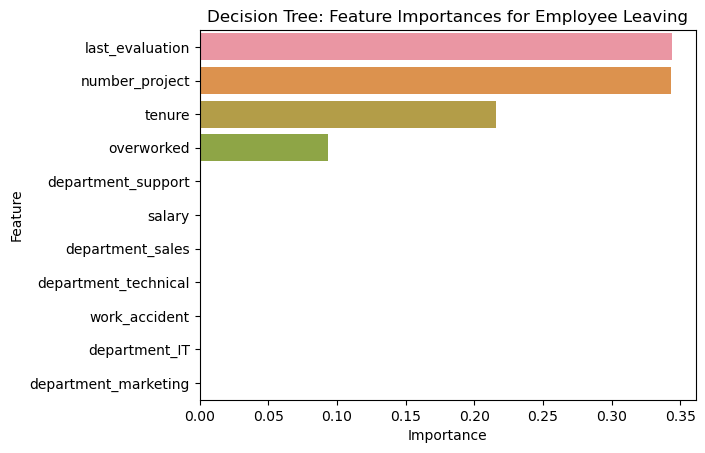

In [297]:
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The barplot above shows that in this decision tree model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting whether a employee would leave the company.

### 4. Random Forest with Feature Engineering

In [298]:
# Build RF model
rf = RandomForestClassifier(random_state=0)

# Hyperparameter Options
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Scoring metrics 
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [299]:
%%time
rf2.fit(X_train, y_train)

CPU times: user 8min 47s, sys: 18.4 s, total: 9min 6s
Wall time: 9min 11s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [300]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [301]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [302]:
# Check best params
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [303]:
# Check best AUC score on CV
rf2.best_score_

0.9648089938973397

In [304]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)
print(rf1_cv_results)
print(rf2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.856693  0.903553  0.878882  0.958523  0.958675
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.866758  0.878754  0.872407  0.957411  0.964809


In [305]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
print(tree1_test_scores)
print(rf1_test_scores)
print(tree2_test_scores)
print(rf2_test_scores)

                 model  precision    recall        f1  accuracy       AUC
0  Decision tree1 test   0.936214  0.913655  0.924797  0.975317  0.950627
                 model  precision    recall        f1  accuracy       AUC
0  Random Forest1 test   0.964211  0.919679  0.941418  0.980987  0.956439
                 model  precision    recall        f1  accuracy       AUC
0  Decision tree2 test   0.783877  0.917671  0.845513  0.944296  0.933635
                 model  precision    recall      f1  accuracy       AUC
0  random forest2 test   0.870406  0.903614  0.8867  0.961641  0.938407


The ROC AUC score for the random forest model with feature engineering is 93.8%, showing a slight improvement in performance compared to the single decision tree model.

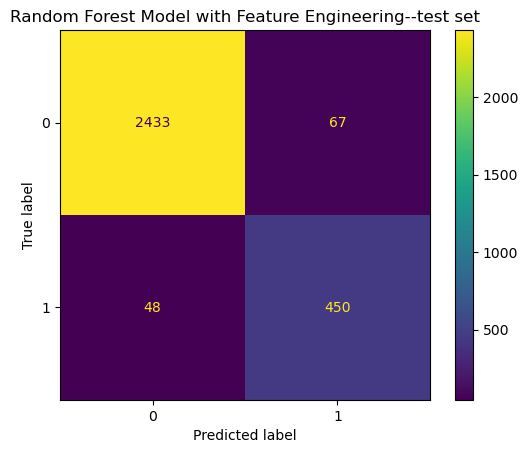

In [306]:
# Confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');
plt.title('Random Forest Model with Feature Engineering--test set')
#plt.savefig('Random Forest Model with Feature Engineering--test set', dpi=300)
plt.show()

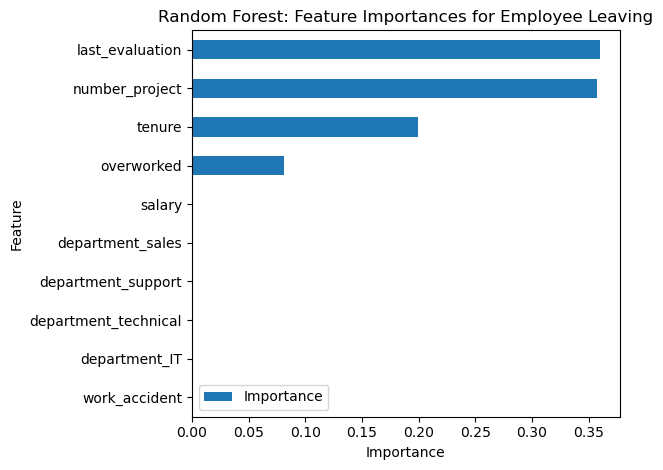

In [309]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X_fe.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")
plt.tight_layout()
#plt.savefig('Random_Forest_Feature_Importances_for_Employee_Leaving.png', dpi=300, bbox_inches='tight')
plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

# V. Conclusion

Based on the results of the exploratory data analysis (EDA), statistical tests, and feature importance rankings from the machine learning model, several recommendations can be made for HR to improve employee retention and performance.

1. Reduce Project Overload: Employees are currently managing an excessive number of projects, leading to overwork. Consider redistributing workloads to improve productivity and well-being.

2. Evaluation Policy Review: Conduct research to gather feedback on the effectiveness of current evaluation policies. Develop new, more effective policies based on employee input.

3. Implement a Recognition Program: Establish a rewards program to recognize and incentivize employees who consistently put in extra effort and time.

4. Understand Turnover Causes: Investigate the root causes of employee turnover, acknowledging that not all departures stem from low job satisfaction. Identify additional factors.

5. Workshops for Underperforming Employees: Organize workshops aimed at employees who did not meet project expectations to provide them with the skills and support needed for improvement.